In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import glob
import pydicom
import copy
from skimage import transform
import pybboxes as pbx

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# !pip install -q super_gradients==3.6.0
# !pip install pybboxes

In [3]:
stdout = sys.stdout

from super_gradients.training import models
from super_gradients.training import training_hyperparams
from super_gradients.training.utils.collate_fn.detection_collate_fn import DetectionCollateFN

sys.stdout = stdout

In [4]:
!pwd

/Users/dmtragfnv/hackathons/int20h_2024/INT20H_RSNA_Pneumonia_Detection_4NN/Notebooks


In [5]:
!ls

data_generator.ipynb
data_loader_baseline.ipynb
detection_how_to_connect_custom_dataset.ipynb
example_data
exploratory-data-analysis.ipynb
lung-opacity-overview.ipynb
transfer_learning.ipynb


In [6]:
%cd ../

/Users/dmtragfnv/hackathons/int20h_2024/INT20H_RSNA_Pneumonia_Detection_4NN


# 1. Data definition

In [7]:
DATA_DIR = 'Data'

train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')
annotation_metadata_dir = os.path.join(DATA_DIR, 'image_bbox_full.csv')

In [8]:
metadata_df = pd.read_csv(annotation_metadata_dir)
metadata_df.head()

,patientId,x,y,width,height,Target,class,boxes,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../Data/stage_2_train_images/0004cfab-14fd-4e4...
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../Data/stage_2_train_images/000924cf-0f8d-42b...
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../Data/stage_2_train_images/000fe35a-2649-43d...


In [9]:
metadata_df.loc[:, "coords"] = metadata_df.loc[:, ["Target", "x", "y", "width", "height"]].values.tolist()
metadata_df.head()

,patientId,x,y,width,height,Target,class,boxes,path,coords
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,../Data/stage_2_train_images/0004cfab-14fd-4e4...,"[0.0, nan, nan, nan, nan]"
1,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,1,../Data/stage_2_train_images/000924cf-0f8d-42b...,"[0.0, nan, nan, nan, nan]"
2,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...,"[1.0, 316.0, 318.0, 170.0, 478.0]"
3,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,2,../Data/stage_2_train_images/000db696-cf54-438...,"[1.0, 660.0, 375.0, 146.0, 402.0]"
4,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1,Lung Opacity,2,../Data/stage_2_train_images/000fe35a-2649-43d...,"[1.0, 570.0, 282.0, 269.0, 409.0]"


In [10]:
metadata_df.loc[:, "patientId"].nunique(), \
    metadata_df.loc[metadata_df["Target"] != 0, "patientId"].nunique(), \
    metadata_df.loc[metadata_df["Target"] == 0, "patientId"].nunique()

(26684, 6012, 20672)

In [11]:
# def func(x):
#     if x.shape[0] > 1:
#         return list(x)
#     else:
#         return x

# metadata_df.groupby("patientId")["coords"].agg(func)

In [12]:
grouped_bbox = metadata_df.groupby("patientId")["coords"].agg(list).to_frame()
grouped_bbox

,coords
patientId,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,"[[0.0, nan, nan, nan, nan]]"
000924cf-0f8d-42bd-9158-1af53881a557,"[[0.0, nan, nan, nan, nan]]"
000db696-cf54-4385-b10b-6b16fbb3f985,"[[1.0, 316.0, 318.0, 170.0, 478.0], [1.0, 660...."
000fe35a-2649-43d4-b027-e67796d412e0,"[[1.0, 570.0, 282.0, 269.0, 409.0], [1.0, 83.0..."
001031d9-f904-4a23-b3e5-2c088acd19c6,"[[1.0, 66.0, 160.0, 373.0, 608.0], [1.0, 552.0..."
...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,"[[1.0, 177.0, 285.0, 225.0, 529.0], [1.0, 641...."
fffba05a-1635-4545-9bbd-57ad4cfe8d27,"[[0.0, nan, nan, nan, nan]]"
fffc95b5-605b-4226-80ab-62caec682b22,"[[0.0, nan, nan, nan, nan]]"


In [13]:
metadata_storage = {}

for ind, bbox_values in grouped_bbox.iterrows():
    curr_img_id = os.path.join(train_dicom_dir, f"{ind}.dcm")
    if os.path.isfile(curr_img_id):
        metadata_storage[curr_img_id] = bbox_values.values[0]

In [14]:
len(metadata_storage.keys())

26684

In [15]:
# metadata_storage

In [16]:
len(metadata_storage)

26684

# 2. Create metadata storage structure

In [17]:
def read_meatadata_frame(annotation_directory):
    assert os.path.isfile(annotation_directory), f"No metadata into following dir: {annotation_directory}"

    return pd.read_csv(annotation_directory)


def construct_metadata_df(annotation_directory):
    annotations_df_ = read_meatadata_frame(annotation_directory)
    annotations_df_.loc[:, "coords"] = \
        annotations_df_.loc[:, ["Target", "x", "y", "width", "height"]].values.tolist()
    grouped_bbox_df = annotations_df_.groupby("patientId")["coords"].agg(list).to_frame()
    
    return grouped_bbox_df


def split_train_val(grouped_bbox_df, val_size=0.15):
    val_set = grouped_bbox_df.sample(frac=val_size)    
    train_set = grouped_bbox_df.loc[~grouped_bbox_df.index.isin(val_set.index)]
        
    return train_set, val_set
    
    
def construct_metadata_storage(grouped_bbox_df, data_directory):
    metadata_storage = {}
    for ind, bbox_values in grouped_bbox_df.iterrows():
        curr_img_id = os.path.join(data_directory, f"{ind}.dcm")
        if os.path.isfile(curr_img_id):
            metadata_storage[curr_img_id] = bbox_values.values[0]

    return metadata_storage

In [18]:
grouped_bbox_df = construct_metadata_df(annotation_metadata_dir)

train_grouped_bbox_df, val_grouped_bbox_df = split_train_val(grouped_bbox_df)

train_metadata_storage = construct_metadata_storage(train_grouped_bbox_df, train_dicom_dir)
val_metadata_storage = construct_metadata_storage(val_grouped_bbox_df, train_dicom_dir)

In [19]:
len(train_metadata_storage.keys()), len(val_metadata_storage.keys())

(22681, 4003)

In [20]:
# train_metadata_storage

In [21]:
### plot helpers

def plot_dicom(image_data, bbox_data):
    """
    Takes bbox data in coco format
    """
    plt.imshow(image_data)
    bounding_boxes = bbox_data

    ax = plt.gca()

    for bbox in bounding_boxes:
        class_, xmin, ymin, width, height = bbox
        rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()
    
def plot_dicom_yolo(image_data, bbox_data):
    """
    Takes bbox data in yolo format
    """
    plt.imshow(image_data)
    bounding_boxes = bbox_data
    
    width, height = image_data.shape[:2]

    ax = plt.gca()

    for bbox in bounding_boxes:
        class_, x, y, w, h = bbox
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        rect = Rectangle((x - w / 2, y - h / 2), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# 3. Create Torch Custom Dataset

In [22]:
class CustomImageDataset(Dataset):
    def __init__(self, metadata_storage, transform=None, target_transform=None):
        self.metadata_storage = metadata_storage
        self.transform = transform
        self.target_transform = target_transform
    
    
    def load_bbox(self, idx):
        return np.asarray(list(self.metadata_storage.items())[idx][1])
    
    
    def load_dicom_file_as_image(self, idx, three_channel=True):
        dcm_path = list(self.metadata_storage.items())[idx][0]
        dcm_data = pydicom.read_file(dcm_path)
        image = dcm_data.pixel_array
        
        if three_channel:
            return np.stack([image] * 3, axis=2)
        else:
            return image

        
    def __len__(self):
        return len(self.metadata_storage)
    

    def __getitem__(self, idx):
        image = self.load_dicom_file_as_image(idx)
#         three_channel_image = torch.tensor(three_channel_image, dtype=torch.int16) #.permute(2, 0, 1).float()
        
#         label = np.asarray(list(self.metadata_storage.items())[idx][1])
        label = list(self.metadata_storage.items())[idx][1]
        
#         sample = {"image": image, "labels": label}
    
        if self.target_transform:
            image, label = self.target_transform((image, label))
        
            
        if self.transform:
#             image, label = self.transform((image, label))
            image, label = self.transform(image=image, bboxes=label)
        
        return image, label
    

In [23]:
train_dataset = CustomImageDataset(
    metadata_storage=train_metadata_storage,
#     transform=train_transforms,
#     target_transform=train_transforms_base
)

val_dataset = CustomImageDataset(
    metadata_storage=val_metadata_storage,
#     transform=val_transforms,
#     target_transform=val_transforms_base
)

In [24]:
train_dataset[2][1] 

[[1.0, 316.0, 318.0, 170.0, 478.0], [1.0, 660.0, 375.0, 146.0, 402.0]]

In [25]:
# bbox = copy.deepcopy(train_dataset[2][1] )
# bbox

In [26]:
img, bbox = train_dataset[2][0], train_dataset[2][1] 
bbox

[[1.0, 316.0, 318.0, 170.0, 478.0], [1.0, 660.0, 375.0, 146.0, 402.0]]

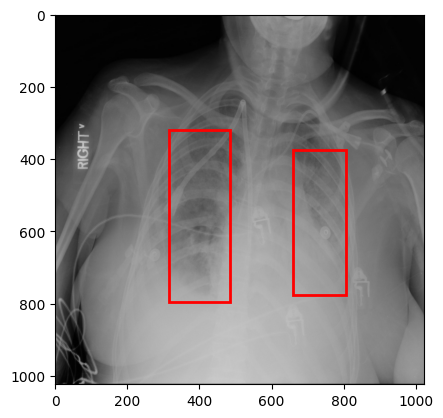

In [27]:
plot_dicom(img, bbox)

# 4. Transformations

In [39]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, labels = sample[0], sample[1]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        
        width_ratio = new_w / w
        hight_ratio = new_h / h
        
        new_labels = []
        
        for ind, value in enumerate(labels):
            new_labels.insert(ind, [value[0]])
            
            upd_bbox = np.asarray(value[1:]) * [
                width_ratio, hight_ratio, width_ratio, hight_ratio
            ]
            
            new_labels[ind].extend(list(upd_bbox))
            

        return img, new_labels
    

class BBoxListConverter(object):
    def __call__(self, sample):
        image, labels = sample[0], sample[1]
        
        # TODO: refactor
        if not np.isnan(labels).any():
            if isinstance(labels, list):
                labels_ = []
                for ind, value in enumerate(labels):
                    labels_.insert(ind, [value[0]])
                    labels_[ind].extend(
                        list(pbx.convert_bbox(
                            value[1:], 
                            from_type="coco", 
                            to_type="yolo", 
                            image_size=image.shape[:2]
                        ))
                    )
            else:
                raise Exception(f"Invalid bbox data type! {type(labels)}")

            return image, labels_
        else:
            return image, labels


class ToTensor(object):
    def __call__(self, sample):
        image, labels = sample[0], sample[1]

#         image = image.transpose((2, 0, 1))
        return torch.tensor(image, dtype=torch.float32), \
            torch.tensor(labels, dtype=torch.float32)

In [40]:
rescale = Rescale(480)
convert_bbox = BBoxListConverter()
to_tensor = ToTensor()



In [95]:
train_transforms_base = transforms.Compose([
    rescale,
    convert_bbox,
    to_tensor,
])

val_transforms_base = transforms.Compose([
    rescale,
    convert_bbox,
    to_tensor,
])

In [96]:
train_dataset = CustomImageDataset(
    metadata_storage=train_metadata_storage,
#     transform=train_transforms,
    target_transform=train_transforms_base
)

val_dataset = CustomImageDataset(
    metadata_storage=val_metadata_storage,
#     transform=val_transforms,
    target_transform=val_transforms_base
)

In [101]:
train_dataset[1][1] 

tensor([[0., nan, nan, nan, nan]])

In [98]:
img, bbox = train_dataset[2][0], train_dataset[2][1] 

In [99]:
# img

In [100]:
bbox

tensor([[1.0000, 0.3917, 0.5437, 0.1667, 0.4667],
        [1.0000, 0.7146, 0.5625, 0.1417, 0.3917]])

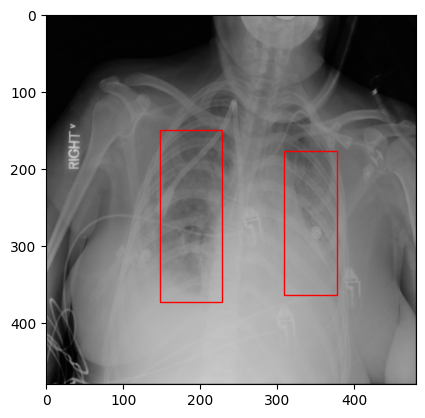

In [47]:
plot_dicom_yolo(img, bbox)

# 5. Create Torch Dataloader

In [48]:
train_dataloader = DataLoader(
    train_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN()
)

val_dataloader = DataLoader(
    val_dataset, batch_size=16, shuffle=False, num_workers=0, collate_fn=DetectionCollateFN()
)

In [49]:
curr_batch = next(iter(train_dataloader))

In [94]:
curr_batch

(tensor([[[[0.4690, 0.3701, 0.2791,  ..., 0.6027, 0.6640, 0.6017],
           [0.3252, 0.2326, 0.1581,  ..., 0.4704, 0.5879, 0.5700],
           [0.1951, 0.1261, 0.0794,  ..., 0.3235, 0.4652, 0.5038],
           ...,
           [0.0423, 0.0272, 0.0192,  ..., 0.0316, 0.0498, 0.0327],
           [0.0540, 0.0332, 0.0221,  ..., 0.0365, 0.0559, 0.0385],
           [0.0653, 0.0408, 0.0280,  ..., 0.0491, 0.0692, 0.0515]],
 
          [[0.4690, 0.3701, 0.2791,  ..., 0.6027, 0.6640, 0.6017],
           [0.3252, 0.2326, 0.1581,  ..., 0.4704, 0.5879, 0.5700],
           [0.1951, 0.1261, 0.0794,  ..., 0.3235, 0.4652, 0.5038],
           ...,
           [0.0423, 0.0272, 0.0192,  ..., 0.0316, 0.0498, 0.0327],
           [0.0540, 0.0332, 0.0221,  ..., 0.0365, 0.0559, 0.0385],
           [0.0653, 0.0408, 0.0280,  ..., 0.0491, 0.0692, 0.0515]],
 
          [[0.4690, 0.3701, 0.2791,  ..., 0.6027, 0.6640, 0.6017],
           [0.3252, 0.2326, 0.1581,  ..., 0.4704, 0.5879, 0.5700],
           [0.1951, 0.12

In [102]:
curr_batch[1][1].shape, curr_batch[0][1].shape, train_dataset[1][0].shape

(torch.Size([6]), torch.Size([3, 480, 480]), torch.Size([480, 480, 3]))

In [51]:
### Reshaping caused by *collate_fn=DetectionCollateFN()*

# https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/utils/collate_fn/detection_collate_fn.py#L28

In [57]:
# def collate_required_reshape(img):
#     images_batch_stack = torch.stack([img], 0)
#     if images_batch_stack.shape[3] == 3:
#         return torch.moveaxis(images_batch_stack, -1, 1).float()
#     else:
#         raise Exception(f"Invalid shape: {images_batch_stack.shape}")
        
# def inverse_collate_required_reshape(transformed_img):
#     return torch.moveaxis(transformed_img, 1, -1) #.float()


In [60]:
# collate_required_reshape(train_dataset[1][0])

In [61]:
# (inverse_collate_required_reshape(collate_required_reshape(train_dataset[1][0])) == train_dataset[1][0]) \
#     .all()

tensor(True)

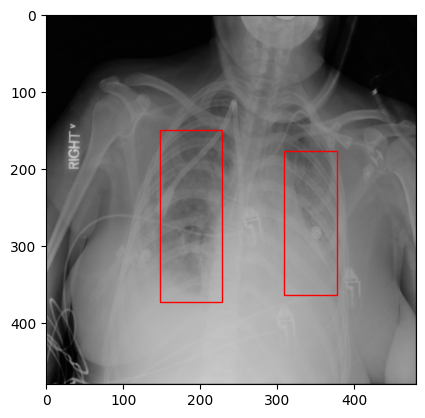

In [80]:
plot_dicom_yolo(
    curr_batch[0][2].permute(1, 2, 0), 
    curr_batch[1][curr_batch[1][:, 0] == 2, 1:]
)

# 5. Architecture definition

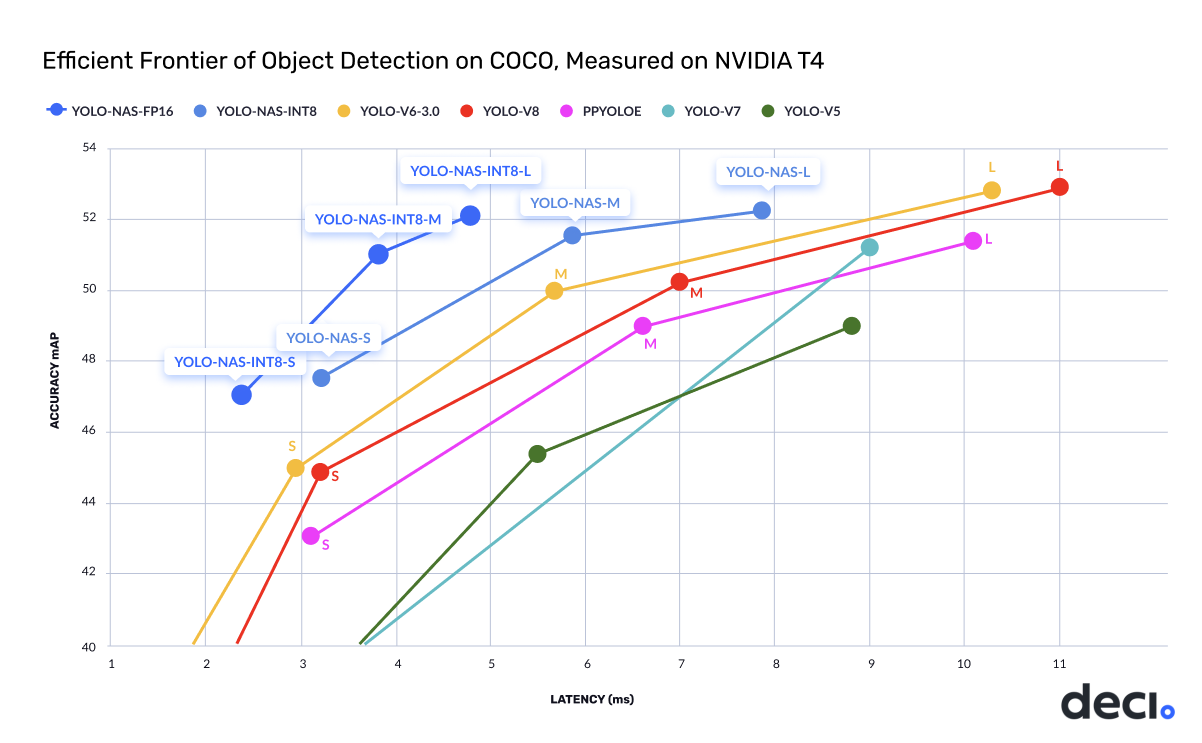

In [107]:
model = models.get("yolo_nas_m", pretrained_weights="coco", num_classes=2)
model.num_classes

2

In [241]:
# !pip install torchinfo

  Using cached torchinfo-1.8.0-py3-none-any.whl.metadata (21 kB)
Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)


In [108]:
from torchinfo import summary

summary(model = model,
       input_size = (1, 3, 480, 480),
       col_names = ['input_size',
                   'output_size',
                   'num_params',
                   'trainable'],
       col_width = 13,
#        row_settings = ['var_names']
    )

Layer (type:depth-idx)                                       Input Shape   Output Shape  Param #       Trainable
YoloNAS_M                                                    [1, 3, 480, 480] [1, 4725, 4]  --            True
├─NStageBackbone: 1-1                                        [1, 3, 480, 480] [1, 96, 120, 120] --            True
│    └─YoloNASStem: 2-1                                      [1, 3, 480, 480] [1, 48, 240, 240] --            True
│    │    └─QARepVGGBlock: 3-1                               [1, 3, 480, 480] [1, 48, 240, 240] 3,024         True
│    └─YoloNASStage: 2-2                                     [1, 48, 240, 240] [1, 96, 120, 120] --            True
│    │    └─QARepVGGBlock: 3-2                               [1, 48, 240, 240] [1, 96, 120, 120] 88,128        True
│    │    └─YoloNASCSPLayer: 3-3                             [1, 96, 120, 120] [1, 96, 120, 120] 350,146       True
│    └─YoloNASStage: 2-3                                     [1, 96, 120, 120] [1, 

# 6. Trining setup

In [109]:
train_params = training_hyperparams.get('training_hyperparams/default_train_params.yaml')
train_params
     

{'resume': False,
 'run_id': None,
 'resume_path': None,
 'resume_from_remote_sg_logger': False,
 'ckpt_name': 'ckpt_latest.pth',
 'lr_mode': None,
 'lr_schedule_function': None,
 'lr_warmup_epochs': 0,
 'lr_warmup_steps': 0,
 'lr_cooldown_epochs': 0,
 'warmup_initial_lr': None,
 'step_lr_update_freq': None,
 'cosine_final_lr_ratio': 0.01,
 'warmup_mode': 'LinearEpochLRWarmup',
 'lr_updates': [],
 'pre_prediction_callback': None,
 'optimizer': 'SGD',
 'optimizer_params': {},
 'load_opt_params': True,
 'zero_weight_decay_on_bias_and_bn': False,
 'loss': None,
 'criterion_params': {},
 'ema': False,
 'ema_params': {'decay': 0.9999, 'decay_type': 'exp', 'beta': 15},
 'train_metrics_list': [],
 'valid_metrics_list': [],
 'metric_to_watch': 'Accuracy',
 'greater_metric_to_watch_is_better': True,
 'launch_tensorboard': False,
 'tensorboard_port': None,
 'tb_files_user_prompt': False,
 'save_tensorboard_to_s3': False,
 'precise_bn': False,
 'precise_bn_batch_size': None,
 'sync_bn': False,
 '

In [110]:
train_params['max_epochs'] = 5
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = 2
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.0005
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False

# 7. Training and evaluation